# Linear/Integer Program
This notebook outlines an integer programming perspective on the Covid-19 scheduling problem. In its current iteration, this model schedules people on a week-by-week basis, ensuring that people take 2 tests per week (if feasible) and attempting to keep the number of tests on any given day below a reasonable bound.

The optimized variable is $x0$, a $(7*number\_of\_people)$-length vector that gives a schedule for each person — the schedule is a subvector of 7 binary digits, with 0 meaning 'no test' and 1 meaning 'test'.

To incorporate people's availabilities (here, availability for a test = on campus that day), we use a $(number\_of\_people) * (7*number\_of\_people)$ matrix $A_{eq}$, which has binary 7-vectors down the diagonal that incorporate people's availabilities (0 = not available, 1 = available). This way, $A_{eq} \cdot x0 $ will return the number of scheduled tests that align with each person's schedule.

We also use a binary matrix $A$ that when dotted with $x0$ gives a 7-vector of total tests per day, to ensure that each day's testing does not exceed a certain threshold. The threshold $b$ is simply the average number of tests per day: $\frac{(number\_of\_people*tests\_per\_week)}{7} * (1 + \mbox{buf})$, where buf is currently set to 0.05.

In [387]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

Below are several (perhaps too many!) functions that make it easier to make sense of the matrices and outcomes of the optimization. Feel free to skip past this code and use the functions only if necessary.

In [366]:
def textSummary():
    for i in range(number_of_people):
        idx = 7*i
        num_tests = 0
        days_avail = 0
        for j in range(7):
            num_tests += x0[idx].x
            days_avail += Aeq[i][idx]
            idx += 1
        if (days_avail < num_tests):
            print("!!! Person %02d: available days = %d --> %d tests !!!" % (i, days_avail, num_tests))
        else:
            print("Person %02d: available days = %d --> %d tests" % (i, days_avail, num_tests))

    print()
    for i in range(7):
        tests = 0
        for j in range(i, 7*number_of_people, 7):
            tests += x0[j].x
        print("On day %d, %d tests" % (i, tests))

def displayAeq():
    fig, ax = plt.subplots(figsize=(16,6))
    cmap = colors.ListedColormap(['gray', 'yellow'])

    ax.imshow(Aeq, cmap=cmap, aspect='auto', extent=[0, 7*number_of_people, number_of_people, 0])
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)

    ax.set_xticks(np.arange(0, 7*number_of_people, 7))
    ax.set_yticks(np.arange(0, number_of_people, 2))
    ax.set_ylabel("Person", fontsize=16)
    ax.set_xlabel("Person-Days [yellow=available]", fontsize=16)
    ax.set_title("Aeq (Availability Matrix)", fontsize=20)

    plt.savefig("Aeq.png")
    plt.show()
    plt.close()
    
def displayA():
    fig, ax = plt.subplots(figsize=(16,6))
    cmap = colors.ListedColormap(['gray', 'yellow'])

    ax.imshow(A, cmap=cmap, aspect='auto', extent=[0, 7*number_of_people, 7, 0])
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)

    ax.set_xticks(np.arange(0, 7*number_of_people, 7))
    ax.set_yticks(np.arange(0, 7, 1))
    ax.set_ylabel("Y Axis", fontsize=16)
    ax.set_xlabel("X Axis", fontsize=16)
    ax.set_title("A ", fontsize=20)

    plt.savefig("A.png")
    plt.show()
    plt.close()

def displaybeq():
    fig, ax = plt.subplots(figsize=(16,6))
    cmap = colors.ListedColormap(['gray', 'yellow'])

    # Turn beq numpy array to a flat list of beq values
    beq_list = [item for sublist in beq.tolist() for item in sublist]

    ax.bar(range(number_of_people), height=beq_list)
    ax.set_yticks(range(0, int(max(beq_list)) + 1, 1))
    ax.set_xticks(range(number_of_people))

    ax.set_ylabel("Number of required tests", fontsize=16)
    ax.set_xlabel("Person", fontsize=16)
    ax.set_title("beq (Testing requirement)", fontsize=20)

    plt.savefig("beq.png")
    plt.show()
    plt.close()
    
def makeCalendars(sol):
    avail = np.zeros((1,7))
    for i in range(number_of_people):
        avail = np.append(avail, [Aeq[i][7*i:7*(i+1)]], axis=0)
    avail = np.delete(avail, obj=0, axis=0)

    sched_list = [sol[i].x for i in range(7*number_of_people)]
    for i in range(len(sched_list)):
        if sched_list[i] == 1:
            sched_list[i] = .5
    sched_list = np.asarray(sched_list)
    sched_list = sched_list.reshape(number_of_people,7)
    overlay = np.add(sched_list, avail)
    return avail, sched_list, overlay

def displayAvail(data):
    fig, ax = plt.subplots(figsize=(8,data.shape[0]/5))
    cmap = colors.ListedColormap(['gray', 'yellow'])

    ax.imshow(data, cmap=cmap, aspect='auto', extent=[0, 7, number_of_people, 0])
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)

    # ax.set_xticks(np.arange(0, 7, 7))
    ax.set_yticks(np.arange(0, number_of_people, 1))
    ax.set_ylabel("Person", fontsize=16)
    ax.set_xlabel("Day [yellow=available]", fontsize=16)
    ax.set_title("Availability Matrix", fontsize=20)

    plt.savefig("avail.png")
    plt.show()
    plt.close()
    
def displaySched(data):
    fig, ax = plt.subplots(figsize=(8,data.shape[0]/5))
    cmap = colors.ListedColormap(['gray', 'green'])

    ax.imshow(data, cmap=cmap, aspect='auto', extent=[0, 7, number_of_people, 0])
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)

    # ax.set_xticks(np.arange(0, 7, 7))
    ax.set_yticks(np.arange(0, number_of_people, 1))
    ax.set_ylabel("Person", fontsize=16)
    ax.set_xlabel("Day [green=scheduled]", fontsize=16)
    ax.set_title("Scheduled Matrix", fontsize=20)

    plt.savefig("sched.png")
    plt.show()
    plt.close()
    
def displayOverlay(data):
    fig, ax = plt.subplots(figsize=(8,data.shape[0]/5))
    cmap = colors.ListedColormap(['gray', 'red', 'yellow', 'green'])

    ax.imshow(data, cmap=cmap, aspect='auto', extent=[0, 7, number_of_people, 0])
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)

    # ax.set_xticks(np.arange(0, 7, 7))
    ax.set_yticks(np.arange(0, number_of_people, 1))
    ax.set_ylabel("Person", fontsize=16)
    ax.set_xlabel("Day [yellow=available, green=scheduled, red if overscheduled]", fontsize=12)
    ax.set_title("Calendar", fontsize=20)

    plt.savefig("overlay.png")
    plt.show()
    plt.close()
    
# Create "spread" metric -- only considers people with 2 tests a week
def spreadCost(x0):
    spread = []
    intervals = []
    
    sched_list = [x0[i].x for i in range(len(x0))]
    sched_list = np.asarray(sched_list)
    sched_list = sched_list.reshape(number_of_people,7)
    
    for week in sched_list:
        scheduled_days = np.where(week!=0)
        if len(scheduled_days[0]) == 2:
            intervals.append(scheduled_days[0][1] - scheduled_days[0][0])
    for interval in intervals:
        spread.append((interval - 3.5) ** 2)
    return sum(spread) / number_of_people

def maxDev(x0):
    avail, sched, overlay = makeCalendars(x0)

    daily_demands = np.multiply(sched.sum(axis=0), 2) # *2 because sched marks a test as 0.5
    exp_supply_per_day = number_of_people * tests_per_week / 7
    max_deviation = max(daily_demands.max() - exp_supply_per_day,
                        exp_supply_per_day - daily_demands.max()) / exp_supply_per_day
    return max_deviation

The schedule(n, t) function sets up the IP problem and optimizes $x0$ according to the constraints we've set out. It returns two floats, an average spread cost (defined above) for the schedule, and the maximum deviation from the average number of tests per week (also defined above).

In [374]:
def schedule(number_of_people, tests_per_week):
    
    tests_per_week = 2
    number_of_people = 1000
    buffer = .05

    availability_matrix = np.random.randint(0,2, size=(number_of_people, 7*number_of_people)) # random availabilities
    # availability_matrix = np.ones((number_of_people, 7*number_of_people)) # pretend everyone is available, always

    # Zero out irrelevant parts of the matrix
    for i in range(len(availability_matrix)):
        if i > 0:
            for j in range(i*7):
                availability_matrix[i][j] = 0
        if i < len(availability_matrix):
            for j in range((i+1)*7, 7*number_of_people):
                availability_matrix[i][j] = 0

    # Dealing with infeasibles...
    people_total_availability = np.sum(availability_matrix, 1)
    infeasible_people = np.where(people_total_availability < tests_per_week)

    # Enforce that everyone gets two tests a week
    Aeq = availability_matrix
    beq = np.multiply(tests_per_week, np.ones((number_of_people,1)))

    # Loosen beq in the case where people aren't available enough
    for i in range(len(infeasible_people[0])):
        beq[infeasible_people[0][i]][0] = people_total_availability[infeasible_people[0][i]]

    # This picks up the number of total tests (per?) person each day of the week
    testing_capacity_matrix = np.zeros((7, 7*number_of_people))
    for i in range(len(testing_capacity_matrix)):
        for j in range(i, 7*number_of_people, 7):
            testing_capacity_matrix[i][j] = 1

    A = testing_capacity_matrix
    b_value = np.ceil((number_of_people*tests_per_week/7) * (1 + buffer))
    b = np.multiply(b_value, np.ones((7,1))) 
    
    m = Model()
    m.setParam('OutputFlag', False)

    # Define our scheduling vector as a variable
    x0 = m.addVars(7*number_of_people, name='x0', vtype=GRB.BINARY) # x \in [0,1]

    m.setObjective(x0.sum(), GRB.MAXIMIZE) # maximize # of tests. perhaps not necessary?
    # m.setObjective(spreadCost(x0), GRB.MINIMIZE) # aim to get tests close to Q3.5, not working!

    # Ax <= b -- load balancing
    for i in range(7):
        m.addConstr(sum(x0[j]*A[i][j] for j in range(7*number_of_people)) <= b[i][0])


    # Aeq x = beq -- enforce test-taking
    for i in range(number_of_people):
        m.addConstr(sum((x0[j])*Aeq[i][j] for j in range(7*i, 7*(i+1))) == beq[i][0])
        m.addConstr(sum((x0[j]) for j in range(7*i, 7*(i+1))) == np.floor(beq[i][0]))

    m.optimize()

    avail, sched, overlay = makeCalendars(x0)

    return spreadCost(x0), maxDev(x0)

Run the optimization many times to get a sense for the distribution of spread costs and max deviations...

In [388]:
%%time

spreadCosts = []
max_deviations = []
for _ in range(100):
    c, d = schedule(2, 1000)
    spreadCosts.append(c)
    max_deviations.append(d)

CPU times: user 4min, sys: 2.51 s, total: 4min 2s
Wall time: 4min 58s


# Visualizations

Check out the distributions based on the above trials

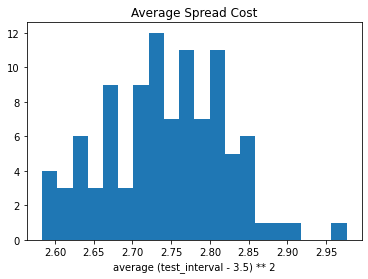

In [389]:
plt.title("Average Spread Cost")
plt.hist(spreadCosts, bins=20)
plt.xlabel("average (test_interval - 3.5) ** 2")
plt.show()

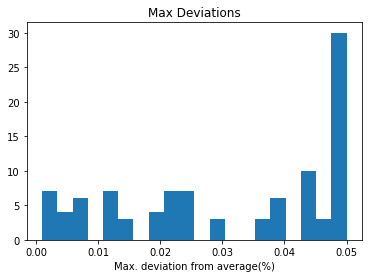

In [390]:
plt.title("Max Deviations")
plt.hist(max_deviations, bins=20)
plt.xlabel("Max. deviation from average(%)")
plt.show()

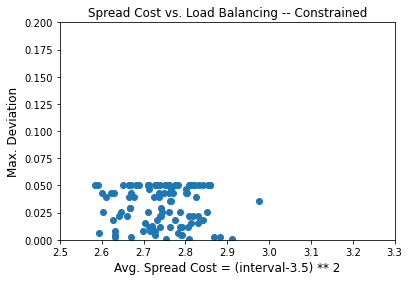

In [391]:
plt.title("Spread Cost vs. Load Balancing -- Constrained")
plt.scatter(spreadCosts, max_deviations)
plt.xlabel("Avg. Spread Cost = (interval-3.5) ** 2", fontsize=12)
plt.ylabel("Max. Deviation", fontsize=12)
plt.ylim(0, 0.2)
plt.xlim(2.5, 3.3)
plt.savefig("CostVsLoad_constrained.png")
plt.show()

# Detailed stats for latest run

Should be similar to Parker's stats

In [392]:
print('Daily demand (min):', daily_demands.min())
print('Daily demand (max):', daily_demands.max())
print('All daily demands:', daily_demands)
exp_supply_per_day = number_of_people * tests_per_week / 7
print(exp_supply_per_day)
max_deviation = max(daily_demands.max() - exp_supply_per_day,
                    exp_supply_per_day - daily_demands.max()) / exp_supply_per_day
print("Max Deviation:", 100 * max_deviation)

Daily demand (min): 255.0
Daily demand (max): 300.0
All daily demands: [300. 255. 270. 279. 263. 294. 266.]
285.7142857142857
Max Deviation: 4.9999999999999964


In [393]:
print("--- Tests by Spacing ---")
for i in range(1,7):
    print('{:d} days: {:d}'.format(i, intervals.count(i)))

--- Tests by Spacing ---
1 days: 259
2 days: 219
3 days: 196
4 days: 133
5 days: 87
6 days: 41


# Visualizing the schedules

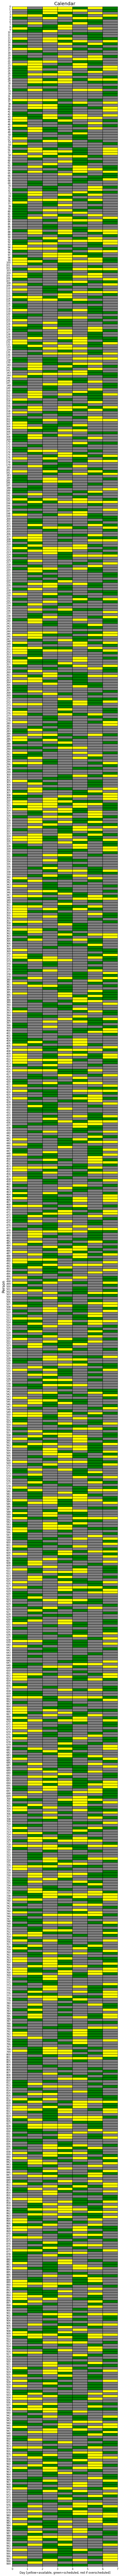

In [394]:
displayOverlay(overlay)

In [ ]:
displayAvail(avail)

In [ ]:
displaySched(sched)